In [11]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, stats, sehgal as ccsehgal, config as cconfig
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy
import pylops
import cupy as cp
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"


In [3]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky/"

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ydel = shape[0] // 9
print(shape, ydel)
template = enmap.zeros(shape, wcs)[ydel*4:(ydel)*5,:]
nshape, nwcs = template.geometry


(21601, 43200) 2400


In [4]:
cuda = True
show_plot=True 
ngpu = 4
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy"
cmb_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat"

experiment_id = "1d2d87ba56dc4b229b4dae000c0e878b"
save_point = 4
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/{}/model".format(experiment_id)
pixgan_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

experiment_id = "ec72a32f599f4ccda54a556ba56abea4"
save_point = 3
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/{}/model".format(experiment_id)
tuner_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

transfer_file = os.path.join(input_dir,"071220_sehgal_network_transferv9.npy")
radio_profile_file = os.path.join(input_dir, "091220_radio_profilev5.npy")
cib_profile_file = os.path.join(input_dir, "091220_cib_profilev4.npy")

output_dir = cconfig.default_output_dir
cache_dir = os.path.join(output_dir, "cache")
sim_dir = os.path.join(output_dir, "sim")

os.makedirs(sim_dir, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)


SN = ccsehgal.SehgalNetwork(nshape, nwcs, cuda, ngpu, 256, norm_info_file, pixgan_state_file,
                          tuner_state_file, spec_file, transfer_file, radio_profile_file, cib_profile_file,20, cache_dir=cache_dir)


Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/1d2d87ba56dc4b229b4dae000c0e878b/model/generator_4.pt
Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/ec72a32f599f4ccda54a556ba56abea4/model/generator_3.pt


In [5]:
test_map_file = os.path.join(input_dir, "test_map.fits")
overwrite = False
if overwrite:
    ngfgmaps = SN.generate_samples(
        seed=0,
        ret_corr=False,
        wrap=True,
        wrap_mode=('reflect', 'wrap'),
        edge_blend=True,
        verbose=True,
        input_kappa=None,
        transfer=False,
        deconv_beam=True,
        use_sht=False,
        post_processes=[],
        use_cache=False,
        flux_cut=None,
        niter_fista=100
    )
    enmap.write_map(test_map_file, ngfgmaps)
else:
    ngfgmaps = enmap.read_map(test_map_file)

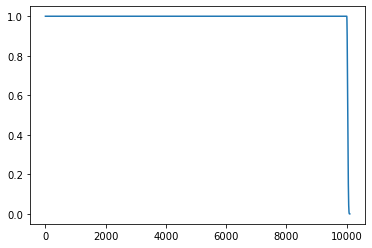

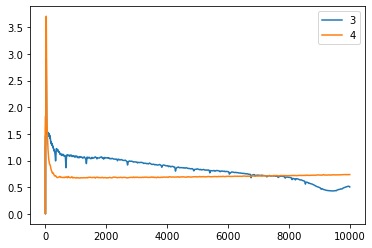

10101
10101


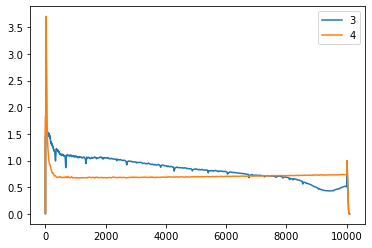

In [6]:
transfer = SN.transfer_func.copy()

lmax = 10000
def fft_taper(lcrit, taper_width=100, order=5):
    ell = np.arange(lcrit+taper_width+1)
    f = np.ones(len(ell))
    f[lcrit:lcrit+taper_width+1] = np.cos(np.linspace(0,np.pi/2,taper_width+1))**5
    f[-1] = 0
    return ell, f

ell, taper = fft_taper(lmax)
plt.plot(ell, taper)
plt.show()

for i in [3,4]:
    ell = transfer[:,0]
    trans = transfer[:,i+1]
    plt.plot(ell, trans, label=i)
plt.legend()
plt.show()

tapered = {}
for i in [3,4]:
    temp = taper.copy()
    print(len(temp))
    temp[:lmax+1] = temp[:lmax+1]* transfer[:,i+1]
    temp[1] = 0
    ell = np.arange(len(temp))
    tapered[i] = (ell,temp)
    plt.plot(ell, temp, label=i)
plt.legend()
plt.show()


In [7]:
sshape, swcs = maps.rect_geometry(3000.5)
modlmap = enmap.modlmap(sshape, swcs)
print(sshape)

(6001, 6001)


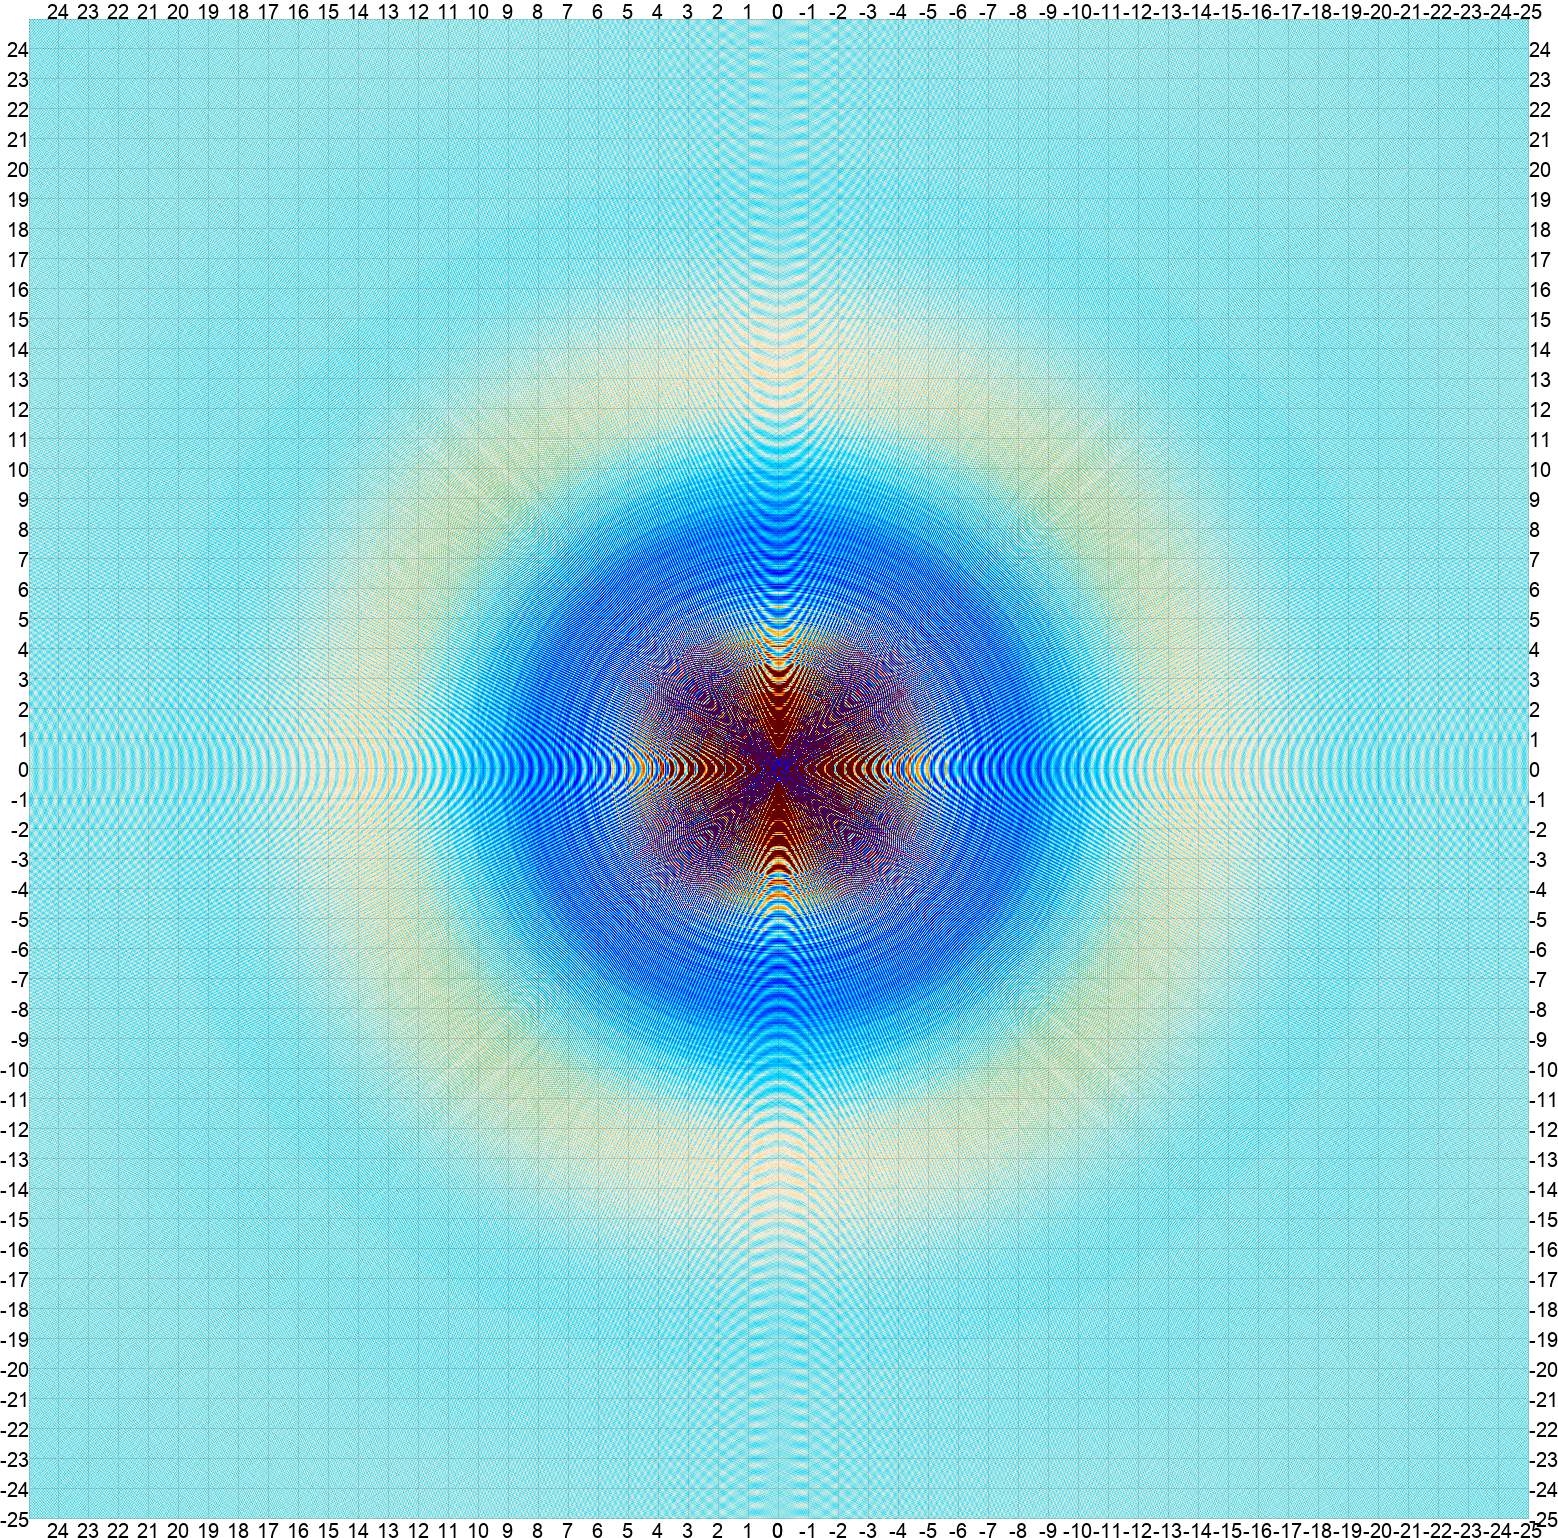

In [9]:
idx = 4
interf = scipy.interpolate.interp1d(transfer[:,0],transfer[:,idx+1], bounds_error=False, fill_value=(transfer[0,idx+1],0))
transf = enmap.zeros(sshape, swcs)
#transf = enmap.fft(transf)
#modlmap = enmap.modlmap(nshape, nwcs)
transf = enmap.enmap(interf(modlmap)+0j, swcs)
transf = enmap.fftshift(enmap.ifft(transf).real)
transf /= np.sum(transf)
enplot.pshow(transf, downgrade=4)

In [13]:
 pylops.signalprocessing.Convolve2D??

In [20]:
cupyx.scipy.linalg.c

<module 'cupyx.scipy.linalg' from '/home/dwhan89/.miniconda3/lib/python3.7/site-packages/cupyx/scipy/linalg/__init__.py'>

In [17]:
import cupyx


In [ ]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

print(0,mempool.used_bytes()/1024**2)              
print(0,mempool.total_bytes()/1024**2)             
print(0,pinned_mempool.n_free_blocks()/1024**2)  
#Cop = pylops.signalprocessing.ConvolveND(np.product(nshape), h=cp.array(transf),
#                                         offset=(sshape[0] // 2,
#                                                 sshape[1] // 2),
#                                         dirs=[0],
#                                         dims=(nshape[0], nshape[1]), dtype='float32', method="direct")

convolved = scipy.signal.convolve2d(ngfgmaps[-1], transf)
#convolved = (Cop*ngfgmaps[-1].flatten()).reshape(nshape)

#del Cop

print(0,mempool.used_bytes()/1024**2)              
print(0,mempool.total_bytes()/1024**2)             
print(0,pinned_mempool.n_free_blocks()/1024**2)  
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()



In [ ]:
enplot.pshow(convolved[:128,:128])
enplot.pshow(ngfgmaps[-1][:128,:128])

In [ ]:

def bin(input, minval, maxval, nbins):
    FB = stats.FastBINNER(minval,maxval,nbins)
    return FB.bin(input)

ell, binned1 = bin(ngfgmaps[-2]/ccsehgal.jysr2thermo(148)*ngfgmaps.pixsizemap()*1e3, -10,10,100)
ell, binned2 = bin(convolved/ccsehgal.jysr2thermo(148)*ngfgmaps.pixsizemap()*1e3, -10,10,100)

In [ ]:
plt.plot(ell, binned1)
plt.plot(ell, binned2)
plt.yscale("log")